_unchecked_

# CNTK 200: 导游

本教程公开了 CNTK 的许多高级功能, 并面向那些以前接触过深入学习和/或其他深层学习工具包的人。如果你是一个完整的初学者, 我们建议你开始与 CNTK 101 教程, 来到这里后, 你已经涵盖了大部分的100系列。

欢迎来到 CNTK!深层神经网络正在重新定义计算机程序的创建方式。除了必需的、功能性的、声明式编程之外, 我们现在还有可微编程, 有效地从数据中 "学习" 程序。

CNTK 是 Microsoft 产品组用来为整个产品系列创建深度模型的主要工具, 从语音识别和机器翻译到通过各种图像分类服务到 Bing 搜索排名。

本教程是导游 CNTK。它的主要目的是为用户是新的 CNTK, 但有一定的经验, 深神经网络。
重点将是如何在 CNTK 的基本步骤进行深入的学习, 我们将主要以实例显示。
此教程不是完整的 API 描述。相反, 我们将读者参考文档和特定于任务的教程, 以获取更详细的信息。

为了训练一个深模型, 你需要定义你的模型结构, 准备你的数据, 以便它可以被 CNTK, 训练模型并评估它的准确性, 并进行部署。

这次导游安排如下:

- 定义**模型结构**

- CNTK 编程模型: 网络作为功能对象

- CNTK 的数据模型: 张量和张张序列

- 您的第一个 CNTK 网络: 逻辑回归

- 您的第二个 CNTK 网络: MNIST 数字识别

- 图形 API: MNIST 数字识别

- 喂养**数据**

- 适合内存的小型数据集: numpy/scipy 阵列/

- 大型数据集: `MinibatchSource` 类

- 勺子喂养数据: 您自己的 minibatch 循环

- **培训**

- 分布式培训

- 记录

- 检查

- 基于交叉验证的培训控制

- 最终评估

- **部署**模型

- 从 Python

- 从 c++ 和 c#

- 从您自己的 web 服务

- 通过 Azure web 服务

- 结论

要运行本教程, 您将需要 CNTK v2 和理想的 CUDA 的 GPU (深入学习是没有 gpu 的乐趣)。

我们从一些导入, 我们将使用在其余的教程。

In [1]:
from __future__ import print_function
import cntk
import numpy as np
import scipy.sparse
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
cntk.cntk_py.set_fixed_random_seed(1) # fix the random seed so that LR examples are repeatable
from IPython.display import Image
import matplotlib.pyplot
%matplotlib inline
matplotlib.pyplot.rcParams['figure.figsize'] = (40,40)

_unchecked_

## 定义模型结构

让我们潜水吧下面我们将介绍 CNTK 的数据模型和 CNTK 的编程模型--*网络是函数对象*(即网络可以像函数一样调用, 并且它还拥有在学习过程中得到调整的某些状态、权重或参数)。我们将使用 CNTK 的功能 API 将其应用于逻辑回归和 MNIST 数字识别。最后, CNTK 还有一个较低级别的图形 API。我们将用它来复制一个例子。

### CNTK 编程模型: 网络是功能对象

在 CNTK 中, 神经网络是一个函数对象。
一方面, CNTK 中的神经网络只是一个函数, 您可以调用它将其应用于数据。
另一方面, 神经网络包含可以像对象成员一样访问的学习参数。
复杂的网络可以组成简单的层次结构, 例如, 表示层。
函数对象方法类似于[Keras](https://keras.io)、[链接](http://chainer.org)、 [Dynet](https://github.com/clab/dynet)、 [Pytorch](http://pytorch.org/)和[十四行诗](https://github.com/deepmind/sonnet)。

下面用完全连接的层 (称为在 CNTK 中) 的例子说明了函数对象方法和**伪代码** `Dense` :

In [2]:
# *Conceptual* numpy implementation of CNTK's Dense layer (simplified, e.g. no back-prop)
def Dense(out_dim, activation):
    # create the learnable parameters
    b = np.zeros(out_dim)
    W = np.ndarray((0,out_dim)) # input dimension is unknown
    # define the function itself
    def dense(x):
        if len(W) == 0: # first call: reshape and initialize W
            W.resize((x.shape[-1], W.shape[-1]), refcheck=False)
            W[:] = np.random.randn(*W.shape) * 0.05
        return activation(x.dot(W) + b)
    # return as function object: can be called & holds parameters as members
    dense.W = W
    dense.b = b
    return dense

d = Dense(5, np.tanh)    # create the function object
y = d(np.array([1, 2]))  # apply it like a function
W = d.W                  # access member like an object
print('W =', d.W)
print('y =', y)

W = [[-0.04255305 -0.00306212 -0.06292971 -0.00450488 -0.0248121 ]
 [-0.03296314  0.00635099 -0.1045115  -0.00292458  0.0368143 ]]
y = [-0.1080558   0.00963955 -0.26544091 -0.01035366  0.04877776]


_unchecked_

同样, 这只是**伪代码**。实际上, CNTK 函数对象不受 numpy 数组的支持。
相反, 它们在内部作为图形结构在 c++ 中表示, 它对计算进行编码, 类似于其他深层学习工具包。事实上, 线

`python
d = Dense(5, np.tanh)`

只是 construsting 图, 而线

`python
y = d(np.array([1, 2]))`

正在将数据送到图形执行引擎。

此图结构被封装在 python 类 `Function` 中, 它公开必要的接口, 以便其他 python 函数可以调用它并访问其成员 (如 `W` 和 `b` )。

函数对象是 CNTK 的单一抽象, 用于表示不同的操作, 它们仅由约定加以区分:

- 没有学习参数的**基本操作**(例如 `+` 、 `*` 、 `sigmoid()` ...)

- **图层**(`Dense()`, `Embedding()`, `Convolution()`...).图层将一个输入映射到一个输出, 并且可能有学习参数附加到它们。

- **经常性步骤函数**(`LSTM()`, `GRU()`, `RNNStep()`).步骤函数将上一个状态和新输入映射到新状态。

- **损耗和跃点数**函数 ( `cross_entropy_with_softmax()` 、 `binary_cross_entropy()` 、 `squared_error()` 、. `classification_error()` ..)。
   在 CNTK, 损失和公制不是特别的, 它们只是功能。唯一的区别是, 虽然 CNTK 函数可以有一个或多个输出, 但损耗和跃点数必须具有单个输出。请注意, 损失不必输出标量值: 如果损失的输出不是标量, CNTK 将自动将损失定义为输出的总和。通过显式执行缩减操作, 可以重写此行为。

- **模型**。模型由用户定义。模型将功能映射到预测或分数, 并将其部署到最后。

- **条件函数**。标准作用映射 (特征, 标签) 到损失和可选择地一个跃点数。
   培训师通过 SGD 优化损失, 并记录指标。该度量可以是非可微的, 但损失必须是可微分的。

高阶层将对象组合成更复杂的层次, 包括:

- 层**堆叠**( `Sequential()` , `For()` )

- **重复周期**(`Recurrence()`, `Fold()`, `UnfoldFrom()`, ...)

网络通常是通过使用现有的 CNTK 函数 (如特定类型的神经网络层) 来定义的, 并使用 `Sequential()` 进行组合。
此外, 用户可以将自己的函数编写为任意的 Python 表达式, 只要这些功能由 CNTK 的操作组成 CNTK 数据类型。
Python 表达式通过将它们包装在对 `Function()` 的调用中来转换为内部表示形式。可以通过修饰符语法 ( `@Function` ) 将表达式写成多行函数。

即使无法通过组合 CNTK 的基元来表示操作, 也存在通过在 Python 中 (或在 c++ 中) 编写自己的 "层" 来[扩展 CNTK](https://www.cntk.ai/pythondocs/extend.html)的机制。这是先进的功能, 你不应该担心现在, 但它的好, 知道它的情况下, 你需要它。

最后, CNTK 函数对象实现了简单的参数共享。如果在多个位置调用同一函数对象, 则所有调用都将自然共享相同的学习参数。
为了避免共享参数, 您只需创建两个不同的函数对象即可。

总之, 函数对象是 CNTK 的单一抽象, 用于方便地定义简单和复杂的模型、参数共享和培训目标。

也可以直接根据其底层图形操作 (类似于许多其他工具包) 来定义 CNTK 网络。您可以在定义神经网络的两种风格之间自由地*混合和匹配*。下面将进一步讨论这一点。

### CNTK 的数据模型: 张量序列

CNTK 可以对两种类型的数据进行操作:

- 张量**None**(即 N 维数组), 稠密或稀疏

- 张量的**序列**

区别是张量的形状在操作期间是静态的, 而序列的长度取决于数据。
在 CNTK 中, 我们使用轴来表示与 numpy 数组的维度相同的东西, 即形状的张量 (7106) 有三*轴*。
张量具有*静态轴*, 而序列有一个附加的*动态轴*。
因此, 动态轴是可变长度轴。

分类数据表示为稀疏的单热张量 (即, 除单个1之外的所有元素, 在它所编码的类别的位置上是 0)。
这允许以统一的方式编写嵌入和损失函数作为矩阵产品。

打印 CNTK 函数将为您提供类似于以下格式的输出:

*操作*(序列 [张量 [*形状*],*其他参数*)-> 张量 [*形状*]

当*操作*为 `Composite` 该函数表示它下面的整个关系图时, 所显示的只是最后一个操作。这个图有一定数量的输入, 期望特定类型的输入。在打印函数时, 您将注意到不**存在批处理维度**。CNTK 隐藏用户的批处理。我们希望用户在张量和序列的思考, 并留下迷你配料到 CNTK。与其他工具包不同, CNTK 还可以自动将不同长度的序列批处理为一个 minibatch, 并处理所有必要的填充和包装。不需要类似 "桶" 这样的变通方法。我们从静态轴 separatring 动态轴 (批处理和序列) 的原因是因为只有很少的操作会影响这些轴。默认情况下, 您希望对批处理中的每个示例和序列中的每个元素执行一些步骤。只有很少的特殊操作 (如重复或批处理正常化) 需要处理这些轴。

_unchecked_

### 您的第一个 CNTK 网络: 简单的逻辑回归

让我们把这一切付诸行动, 为一个非常简单的例子, 逻辑回归。
在这个例子中, 我们创建了一个2维正态分布数据点的综合数据集, 它应该被归类为属于两个类之一。
请注意, CNTK 希望标签作为一个热编码。

In [3]:
input_dim_lr = 2    # classify 2-dimensional data
num_classes_lr = 2  # into one of two classes

# This example uses synthetic data from normal distributions,
# which we generate in the following.
#  X_lr[corpus_size,input_dim] - input data
#  Y_lr[corpus_size]           - labels (0 or 1), one-hot-encoded
np.random.seed(0)
def generate_synthetic_data(N):
    Y = np.random.randint(size=N, low=0, high=num_classes_lr)  # labels
    X = (np.random.randn(N, input_dim_lr)+3) * (Y[:,None]+1)   # data
    # Our model expects float32 features, and cross-entropy
    # expects one-hot encoded labels.
    Y = scipy.sparse.csr_matrix((np.ones(N,np.float32), (range(N), Y)), shape=(N, num_classes_lr))
    X = X.astype(np.float32)
    return X, Y
X_train_lr, Y_train_lr = generate_synthetic_data(20000)
X_test_lr,  Y_test_lr  = generate_synthetic_data(1024)
print('data =\n', X_train_lr[:4])
print('labels =\n', Y_train_lr[:4].todense())

data =
 [[ 2.2741797   3.56347561]
 [ 5.12873602  5.79089499]
 [ 1.3574543   5.5718112 ]
 [ 3.54340553  2.46254587]]
labels =
 [[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]


_unchecked_

我们现在定义模型函数。模型函数将输入数据映射到预测。
这是培训过程的最终成果。
在这个例子中, 我们使用最简单的所有模型: 逻辑回归。

In [4]:
model_lr_factory = cntk.layers.Dense(num_classes_lr, activation=None)
x = cntk.input_variable(input_dim_lr)
y = cntk.input_variable(num_classes_lr, is_sparse=True)
model_lr = model_lr_factory(x)

_unchecked_

接下来, 我们定义了标准函数。标准函数是训练器用来优化模型的工具: 它映射 (输入向量、标签) 到 (损耗、跃点数)。
该损失用于 SGD 更新。我们选择交叉熵。
具体地说, `cross_entropy_with_softmax()` 首先将 `softmax()` 函数应用于网络的输出, 因为交叉熵预期概率。
我们不在模型函数本身中包含 `softmax()` , 因为不需要使用模型。
作为度量, 我们计算分类错误 (这个度量不是可微的)。

我们将标准函数定义为 Python 代码, 并将其转换为 `Function` 对象。
单个表达式可以写成 `Function(lambda x, y:` *x 和 y 的表达式* `)` , 类似于 Keras 的 `Lambda()` 。
为了避免对模型进行两次评估, 我们使用了一个 Python 函数定义和修饰符语法。这也是一个好时机, 告诉 CNTK 我们输入的数据类型, 这是通过修饰 `@Function` 完成的:

In [5]:
@cntk.Function
def criterion_lr_factory(data, label_one_hot):
    z = model_lr_factory(data)  # apply model. Computes a non-normalized log probability for every output class.
    loss = cntk.cross_entropy_with_softmax(z, label_one_hot) # applies softmax to z under the hood
    metric = cntk.classification_error(z, label_one_hot)
    return loss, metric
criterion_lr = criterion_lr_factory(x, y)
print('criterion_lr:', criterion_lr)

criterion_lr: Composite(Tensor[2], SparseTensor[2]) -> Tuple[Tensor[1], Tensor[1]]


_unchecked_

修饰者将 "编译" Python 函数到 CNTK 的内部图形表示中。
因此, 结果 `criterion` 不是 Python 函数而是 CNTK `Function` 对象。

我们现在已经准备好训练我们的模型了。

In [6]:
learner = cntk.sgd(model_lr.parameters,
                   cntk.learning_parameter_schedule(0.1))
progress_writer = cntk.logging.ProgressPrinter(0)

criterion_lr.train((X_train_lr, Y_train_lr), parameter_learners=[learner],
                   callbacks=[progress_writer])

print(model_lr.W.value) # peek at updated W

 average      since    average      since      examples
    loss       last     metric       last              
 ------------------------------------------------------
Learning rate per minibatch: 0.1
     3.58       3.58      0.562      0.562            32
     1.61      0.629      0.458      0.406            96
      1.1      0.715      0.464      0.469           224
     0.88      0.688      0.454      0.445           480
    0.734      0.598      0.427      0.402           992
    0.637      0.543      0.351      0.277          2016
    0.541      0.447      0.257      0.165          4064
     0.45      0.359      0.186      0.115          8160
    0.366      0.284      0.137     0.0876         16352
[[-1.25055373 -0.53687984]
 [-0.99188507 -0.30086043]]


_unchecked_

`learner`是实际执行模型更新的对象。替代学习者包括 `momentum_sgd()` 和 `adam()` 。`progress_writer`是一个股票记录回调, 用于打印您在上面看到的输出, 并可以由您自己或股票替换 `TensorBoardProgressWriter` , 以直观地显示使用 TensorBoard 的培训进度。

`train()`函数正在向模型中 minibatch minibatch, 并将其更新, 其中数据是与 `criterion_lr()` 的参数顺序相同的元组。

让我们测试一下我们是如何在我们的测试集 (这也将运行 minibatch 由 minibatch)。

In [7]:
test_metric_lr = criterion_lr.test((X_test_lr, Y_test_lr),
                                   callbacks=[progress_writer]).metric

Finished Evaluation [1]: Minibatch[1-32]: metric = 8.11% * 1024;


_unchecked_

最后, 让我们通过我们的模型运行一些样本, 看看它是如何做。
哎呀, `criterion` 知道输入类型, 但 `model_lr` 没有, 所以我们告诉它。

In [8]:
model_lr = model_lr_factory(x)
print('model_lr:', model_lr)

model_lr: Dense(Tensor[2]) -> Tensor[2]


_unchecked_

现在我们可以像任何 Python 函数那样调用它:

In [9]:
z = model_lr(X_test_lr[:20])
print("Label    :", [label.todense().argmax() for label in Y_test_lr[:20]])
print("Predicted:", [z[i,:].argmax() for i in range(len(z))])

Label    : [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1]
Predicted: [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]


_unchecked_

### 您的第二个 CNTK 网络: MNIST 数字识别

让我们在实际任务上做同样的事情--MNIST 的基准, 这是一种深学习的 "hello 世界"。
MNIST 的任务是识别手写数字的扫描。我们首先下载并准备数据。
在教程103C 中, 您可以找到一种更简洁的方法, 使用内置 CNTK 的便利功能编写整个 MNIST 数字识别工作流

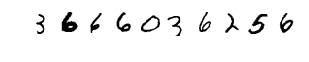

In [10]:
input_shape_mn = (28, 28)  # MNIST digits are 28 x 28
num_classes_mn = 10        # classify as one of 10 digits

# Fetch the MNIST data. Best done with scikit-learn.
try:
    from sklearn import datasets, utils
    mnist = datasets.fetch_mldata("MNIST original")
    X, Y = mnist.data / 255.0, mnist.target
    X_train_mn, X_test_mn = X[:60000].reshape((-1,28,28)), X[60000:].reshape((-1,28,28))
    Y_train_mn, Y_test_mn = Y[:60000].astype(int), Y[60000:].astype(int)
except: # workaround if scikit-learn is not present
    import requests, io, gzip
    X_train_mn, X_test_mn = (np.fromstring(gzip.GzipFile(fileobj=io.BytesIO(requests.get('http://yann.lecun.com/exdb/mnist/' + name + '-images-idx3-ubyte.gz').content)).read()[16:], dtype=np.uint8).reshape((-1,28,28)).astype(np.float32) / 255.0 for name in ('train', 't10k'))
    Y_train_mn, Y_test_mn = (np.fromstring(gzip.GzipFile(fileobj=io.BytesIO(requests.get('http://yann.lecun.com/exdb/mnist/' + name + '-labels-idx1-ubyte.gz').content)).read()[8:], dtype=np.uint8).astype(int) for name in ('train', 't10k'))

# Shuffle the training data.
np.random.seed(0) # always use the same reordering, for reproducability
idx = np.random.permutation(len(X_train_mn))
X_train_mn, Y_train_mn = X_train_mn[idx], Y_train_mn[idx]

# Further split off a cross-validation set
X_train_mn, X_cv_mn = X_train_mn[:54000], X_train_mn[54000:]
Y_train_mn, Y_cv_mn = Y_train_mn[:54000], Y_train_mn[54000:]

# Our model expects float32 features, and cross-entropy expects one-hot encoded labels.
Y_train_mn, Y_cv_mn, Y_test_mn = (scipy.sparse.csr_matrix((np.ones(len(Y),np.float32), (range(len(Y)), Y)), shape=(len(Y), 10)) for Y in (Y_train_mn, Y_cv_mn, Y_test_mn))
X_train_mn, X_cv_mn, X_test_mn = (X.astype(np.float32) for X in (X_train_mn, X_cv_mn, X_test_mn))

# Have a peek.
matplotlib.pyplot.rcParams['figure.figsize'] = (5, 0.5)
matplotlib.pyplot.axis('off')
_ = matplotlib.pyplot.imshow(np.concatenate(X_train_mn[0:10], axis=1), cmap="gray_r")

_unchecked_

让我们定义 CNTK 模型函数来映射 (28x28) 维图像到一个10维的分数向量。我们将其封装在一个函数中, 以便在本教程的后面部分可以轻松地重新创建它。
对于那些熟悉教程103D 的人, 您将学习如何使用层库来组成更大的网络, 以简单的方式对它们进行培训和测试。

In [11]:
def create_model_mn_factory():
    with cntk.layers.default_options(activation=cntk.ops.relu, pad=False):
        return cntk.layers.Sequential([
            cntk.layers.Convolution2D((5,5), num_filters=32, reduction_rank=0, pad=True), # reduction_rank=0 for B&W images
            cntk.layers.MaxPooling((3,3), strides=(2,2)),
            cntk.layers.Convolution2D((3,3), num_filters=48),
            cntk.layers.MaxPooling((3,3), strides=(2,2)),
            cntk.layers.Convolution2D((3,3), num_filters=64),
            cntk.layers.Dense(96),
            cntk.layers.Dropout(dropout_rate=0.5),
            cntk.layers.Dense(num_classes_mn, activation=None) # no activation in final layer (softmax is done in criterion)
        ])
model_mn = create_model_mn_factory()

_unchecked_

这个模型稍微复杂一点!它由几个卷积池 layeres 和两个完全连通的层组成, 这是典型的 MNIST。这说明了 CNTK 的功能 API 的几个方面。

首先, 我们使用 CNTK 的层库 ( `cntk.layers` ) 中的函数创建每个层。

其次, 高阶层 `Sequential()` 创建一个新的函数, 它将所有这些层一个接一个地应用。这是已知的[正向函数组合](https://en.wikipedia.org/wiki/Function_composition)。
请注意, 与其他一些工具包不同, 您不能 `Add()` 将更多的层之后用于顺序层。
CNTK 的 `Function` 对象是不可变的, 除了它们的学习参数 (用于编辑 `Function` 对象外, 您可以 `clone()` 它)。
如果您喜欢该样式, 请将您的图层创建为 Python 列表, 并将其传递给 `Sequential()` 。

第三, 上下文管理器 `default_options()` 允许为层的各种可选参数指定默认值, 如激活函数总是 `relu` , 除非重写。

最后, 请注意, `relu` 作为实际函数传递, 而不是字符串。
任何函数都可以是激活函数。
它还可以直接通过 Python lambda, 例如, relu 也可通过说 `activation=lambda x: cntk.ops.element_max(x, 0)` 来手动实现。

标准函数的定义类似于前面的例子, 映射地图 (28x28) 维度特征, 并根据标签的损失和公制。

In [12]:
@cntk.Function
def criterion_mn_factory(data, label_one_hot):
    z = model_mn(data)
    loss = cntk.cross_entropy_with_softmax(z, label_one_hot)
    metric = cntk.classification_error(z, label_one_hot)
    return loss, metric
x = cntk.input_variable(input_shape_mn)
y = cntk.input_variable(num_classes_mn, is_sparse=True)
criterion_mn = criterion_mn_factory(x,y)

_unchecked_

为训练, 让我们投掷动量入混合。

In [13]:
N = len(X_train_mn)
lrs = cntk.learning_parameter_schedule_per_sample([0.001]*12 + [0.0005]*6 + [0.00025]*6 + [0.000125]*3 + [0.0000625]*3 + [0.00003125], epoch_size=N)
momentums = cntk.momentum_schedule_per_sample([0]*5 + [0.9990239141819757], epoch_size=N)
minibatch_sizes = cntk.minibatch_size_schedule([256]*6 + [512]*9 + [1024]*7 + [2048]*8 + [4096], epoch_size=N)

learner = cntk.learners.momentum_sgd(model_mn.parameters, lrs, momentums)

_unchecked_

这看起来有点不寻常。
首先, 将学习速率指定为一个列表 ( `[0.001]*12 + [0.0005]*6 +` ...)。与 `epoch_size` 参数一起, 这告诉 CNTK 使用0.001 为12个世纪, 然后继续0.005 为另外 6, 等等。

第二, 学习率被指定为, 如果它被应用到 minibatch 的大小 1 (每样), 和动量作为一个时间常数。这些值直接指定了每个样本的渐变对模型的贡献的权重, 以及它的贡献如何随着训练的进展而衰减。CNTK 将根据读者提供的数据的实际 minibatch 大小来扩展学习速度和动量。缩放的净效应将使学习速度和动量, 就像它被应用到大小1的 minibatch。此独特的 CNTK 功能允许在不调整这些参数的情况下调整 minibatch 的大小。在这里, 我们成长从256到 4096, 导致3倍的速度接近尾声 (在一个巨人 x) 的操作。

好了, 现在让我们来训练这个模型。在一个泰坦 x, 这将运行大约一分钟。

In [14]:
progress_writer = cntk.logging.ProgressPrinter()
criterion_mn.train((X_train_mn, Y_train_mn), minibatch_size=minibatch_sizes,
                   max_epochs=40, parameter_learners=[learner], callbacks=[progress_writer])
test_metric_mn = criterion_mn.test((X_test_mn, Y_test_mn), callbacks=[progress_writer]).metric

Learning rate per 1 samples: 0.001
Momentum per 1 samples: 0.0
Finished Epoch[1]: loss = 0.690009 * 54000, metric = 23.13% * 54000 376.212s (143.5 samples/s);
Finished Epoch[2]: loss = 0.130801 * 54000, metric = 3.86% * 54000 374.211s (144.3 samples/s);
Finished Epoch[3]: loss = 0.091346 * 54000, metric = 2.61% * 54000 377.380s (143.1 samples/s);
Finished Epoch[4]: loss = 0.073643 * 54000, metric = 2.11% * 54000 373.727s (144.5 samples/s);
Finished Epoch[5]: loss = 0.062448 * 54000, metric = 1.78% * 54000 377.726s (143.0 samples/s);
Momentum per 1 samples: 0.9990239141819757
Finished Epoch[6]: loss = 0.053981 * 54000, metric = 1.57% * 54000 382.536s (141.2 samples/s);
Finished Epoch[7]: loss = 0.047834 * 54000, metric = 1.45% * 54000 362.123s (149.1 samples/s);
Finished Epoch[8]: loss = 0.043945 * 54000, metric = 1.29% * 54000 366.161s (147.5 samples/s);
Finished Epoch[9]: loss = 0.039856 * 54000, metric = 1.19% * 54000 359.380s (150.3 samples/s);
Finished Epoch[10]: loss = 0.037814 * 

_unchecked_

## 图形 API 示例: 再次 MNIST 数字识别

CNTK 还允许使用图形级 API 编写网络。此 API 更详细, 但有时更灵活。下面定义了与上面相同的模型和标准函数, 并且将得到相同的结果。

In [15]:
images = cntk.input_variable(input_shape_mn, name='images')
with cntk.layers.default_options(activation=cntk.ops.relu, pad=False):
    r = cntk.layers.Convolution2D((5,5), num_filters=32, reduction_rank=0, pad=True)(images)
    r = cntk.layers.MaxPooling((3,3), strides=(2,2))(r)
    r = cntk.layers.Convolution2D((3,3), num_filters=48)(r)
    r = cntk.layers.MaxPooling((3,3), strides=(2,2))(r)
    r = cntk.layers.Convolution2D((3,3), num_filters=64)(r)
    r = cntk.layers.Dense(96)(r)
    r = cntk.layers.Dropout(dropout_rate=0.5)(r)
    model_mn = cntk.layers.Dense(num_classes_mn, activation=None)(r)

label_one_hot = cntk.input_variable(num_classes_mn, is_sparse=True, name='labels')
loss = cntk.cross_entropy_with_softmax(model_mn, label_one_hot)
metric = cntk.classification_error(model_mn, label_one_hot)
criterion_mn = cntk.combine([loss, metric])
print('criterion_mn:', criterion_mn)

criterion_mn: Composite(images: Tensor[28,28], labels: SparseTensor[10]) -> Tuple[Tensor[1], Tensor[1]]


_unchecked_

## 数据的喂养

一旦你决定了你的模型结构并定义了它, 你就会面临将你的培训数据 CNTK 培训过程的问题。

上面的示例简单地将数据作为 numpy/scipy 数组进行提要。
这只是 CNTK 提供给培训者的三种方式之一:

1. 作为**numpy 数组**或**scipy 稀疏 (CSR) 矩阵**, 对于只可以加载到 RAM 中的小型数据集。

2. 通过**CNTK 的 MinibatchSource 类**的实例, 对于不适合 RAM 的大型数据集。

3. 当上述不适用时, 通过**显式 minibatch 循环**。

### 1. 通过 Numpy/Scipy 阵列来喂养数据

`train()`and `test()` 函数接受 numpy 数组的元组或 scipy 的稀疏矩阵 (以 CSR 格式) 表示其 `minibatch_source` 参数。
元组成员的顺序必须与 `criterion` 函数 `train()` 或 `test()` 被调用时的参数相同。
对于稠密张量, 请使用 numpy 数组, 而稀疏数据应具有类型 `scipy.sparse.csr_matrix` 。

每个参数都应是 numpy/scipy 数组的 Python 列表, 其中每个列表项都表示一个数据项。对于声明为序列的参数, numpy/scipy 数组的第一个轴 (维) 是序列长度, 而其余的坐标轴是序列中每个元素的形状。不是序列的参数由单个张量组成。形状、数据类型 ( `np.float32/float64` ) 和稀疏必须与参数类型匹配。

作为一种优化, 不是序列的参数也可以作为单个大的 numpy/scipy 数组 (而不是列表) 传递。这就是上面的例子所做的。

请注意, 用户有责任随机化数据。

### 2. 使用 

生产规模的培训数据有时不适合 RAM。对于这种情况, CNTK 提供了 `MinibatchSource` 类, 它提供了:

- 一种**块随机算法**, 它在任何给定时间只保留 RAM 中的一部分数据。

- **分布式读取**, 其中每个工作人员读取不同的子集。

- 图像和图像增强的**转换管线**。

- **组合**跨多个数据类型 (例如, 图像字幕)。

- 透明的**异步加载**, 使 GPU 在读取/准备 minibatch 时不会停滞

目前, `MinibatchSource` 类以 "反" 的形式实现一组有限的数据类型:

- **图像**(`ImageDeserializer`).

- **语音文件**(`HTKFeatureDeserializer`, `HTKMLFDeserializer`).

- CNTK 的**规范文本格式 (周大福)**中的数据, 它由一组命名的特征通道组成, 每个功能频道都包含一个维度的稀疏或密集序列。然后, CTFDeserializer 可以将每个功能通道与您的模型或标准的输入相关联。

下面的使用 `ImageDeserializer` 类的示例显示了常规模式。
对于特定的输入文件格式, 请查阅文档或数据类型的特定教程, 如教程202。

In [16]:
image_width, image_height, num_channels = (32, 32, 3)
num_classes = 1000
def create_image_reader(map_file, is_training):
    transforms = []
    if is_training:  # train uses data augmentation (translation only)
        transforms += [
            cntk.io.transforms.crop(crop_type='randomside', side_ratio=0.8)  # random translation+crop
        ]
    transforms += [  # to fixed size
        cntk.io.transforms.scale(width=image_width, height=image_height, channels=num_channels, interpolations='linear'),
    ]
    # deserializer
    return cntk.io.MinibatchSource(cntk.io.ImageDeserializer(map_file, cntk.io.StreamDefs(
        features = cntk.io.StreamDef(field='image', transforms=transforms),
        labels   = cntk.io.StreamDef(field='label', shape=num_classes)
    )), randomize=is_training, max_sweeps = cntk.io.INFINITELY_REPEAT if is_training else 1)

_unchecked_

### 3. 通过显式 Minibatch 回路给数据喂食

您可以实现自己的 minibatch 循环并调用较低级别的 api `train_minibatch()` 和 `test_minibatch()` , 而不是将数据作为一个整体向 CNTK 的 `train()` 和 `test()` 函数 minibatch。
当数据的格式不适合上述情况时, 例如在动态生成中, 例如在增强学习的变体中, 这是很有用的。`train_minibatch()`and `test_minibatch()` 方法要求您实例化一个类的对象 `Trainer` , 它采用的是 `train()` 的一个参数子集。下面通过显式 minibatch 循环实现了上述的逻辑回归示例:

In [17]:
# Recreate the model, so that we can start afresh. This is a direct copy from above.
model_lr = cntk.layers.Dense(num_classes_lr, activation=None)
@cntk.Function
def criterion_lr_factory(data, label_one_hot):
    z = model_lr(data)  # apply model. Computes a non-normalized log probability for every output class.
    loss = cntk.cross_entropy_with_softmax(z, label_one_hot) # this applies softmax to z under the hood
    metric = cntk.classification_error(z, label_one_hot)
    return loss, metric

x = cntk.input_variable(input_dim_lr)
y = cntk.input_variable(num_classes_lr, is_sparse=True)
criterion_lr = criterion_lr_factory(x,y)

# Create the learner; same as above.
learner = cntk.sgd(model_lr.parameters, cntk.learning_parameter_schedule(0.1))

# This time we must create a Trainer instance ourselves.
trainer = cntk.Trainer(None, criterion_lr, [learner], [cntk.logging.ProgressPrinter(50)])

# Train the model by spoon-feeding minibatch by minibatch.
minibatch_size = 32
for i in range(0, len(X_train_lr), minibatch_size): # loop over minibatches
    x = X_train_lr[i:i+minibatch_size] # get one minibatch worth of data
    y = Y_train_lr[i:i+minibatch_size]
    trainer.train_minibatch({criterion_lr.arguments[0]: x, criterion_lr.arguments[1]: y})  # update model from one minibatch
trainer.summarize_training_progress()

# Test error rate minibatch by minibatch
evaluator = cntk.Evaluator(criterion_lr.outputs[1], [progress_writer]) # metric is the second output of criterion_lr()
for i in range(0, len(X_test_lr), minibatch_size): # loop over minibatches
    x = X_test_lr[i:i+minibatch_size] # get one minibatch worth of data
    y = Y_test_lr[i:i+minibatch_size]
    evaluator.test_minibatch({criterion_lr.arguments[0]: x, criterion_lr.arguments[1]: y})  # test one minibatch
evaluator.summarize_test_progress()

Learning rate per minibatch: 0.1
 Minibatch[   1-  50]: loss = 0.663274 * 1600, metric = 37.31% * 1600;
 Minibatch[  51- 100]: loss = 0.481867 * 1600, metric = 20.56% * 1600;
 Minibatch[ 101- 150]: loss = 0.402196 * 1600, metric = 12.94% * 1600;
 Minibatch[ 151- 200]: loss = 0.386619 * 1600, metric = 13.75% * 1600;
 Minibatch[ 201- 250]: loss = 0.328646 * 1600, metric = 9.19% * 1600;
 Minibatch[ 251- 300]: loss = 0.301831 * 1600, metric = 9.50% * 1600;
 Minibatch[ 301- 350]: loss = 0.299345 * 1600, metric = 9.44% * 1600;
 Minibatch[ 351- 400]: loss = 0.279577 * 1600, metric = 8.94% * 1600;
 Minibatch[ 401- 450]: loss = 0.281061 * 1600, metric = 8.25% * 1600;
 Minibatch[ 451- 500]: loss = 0.261366 * 1600, metric = 7.81% * 1600;
 Minibatch[ 501- 550]: loss = 0.244967 * 1600, metric = 7.12% * 1600;
 Minibatch[ 551- 600]: loss = 0.243953 * 1600, metric = 8.31% * 1600;
Finished Epoch[1]: loss = 0.344399 * 20000, metric = 12.58% * 20000 2.298s (8703.2 samples/s);
Finished Evaluation [2]: Min

_unchecked_

## 培训和评估

在上面的示例中, 我们使用 `train()` 函数进行训练, 并 `test()` 进行评估。
在本节中, 我们要介绍 `train()` 的高级选项:

1. 使用 MPI 在多个 gpu 上进行**分布式培训**。

2. **None**对**进度跟踪**、 **TensorBoard 可视化**、检查点、基于**验证**的培训控制和**测试**进行最终模型的回调。

### 1. 分布式培训

CNTK 使分布式培训变得容易。在该框之外, 它支持三种分布式培训方法:

- 简单的**数据并行**培训。

- **1 位 SGD**。

- **BlockMomentum**。

简单的**数据并行**培训将每个 minibatch 分布在 N 个工作进程上, 每个进程使用一个 GPU。
每次 minibatch 之后, 所有工作人员的渐变都将在更新每个模型副本之前进行聚合。
这通常是足够的卷积网络, 有一个高计算/通信比率。

**1 位 SGD**使用来自本文的技术来加快数据并行培训中的通信步骤. [None](https://www.microsoft.com/en-us/research/publication/1-bit-stochastic-gradient-descent-and-application-to-data-parallel-distributed-training-of-speech-dnns/)这种方法在通信成本成为控制因素的网络中, 如全连通网络和一些经常性的系统, 已被发现是有效的。这种方法已被发现, 只有在良好的速度 ups 最小降低精度。

**BlockMomentum**使用来自本文的技术, 通过仅交换每个 N minibatches 的渐变来 improvs 通信带宽. [None](https://www.microsoft.com/en-us/research/publication/scalable-training-deep-learning-machines-incremental-block-training-intra-block-parallel-optimization-blockwise-model-update-filtering/)

进程是通过 MPI 进行的。因此, CNTK 的分布式培训在一台服务器和多台服务器之间运行。
你所要做的就是

- 在 `distributed_learner` 对象中包装您的学习者

- 执行 Python 脚本, 使用`mpiexec`

遗憾的是, MPI 不能从 Jupyter 的笔记本中使用。下面的示例可以作为一个独立的 Python 脚本在 `Examples/1stSteps/MNIST_Complex_Training.py` 下运行在 MPI 下, 例如在 MSMPI 下作为

`mpiexec -n 4 -lines python -u Examples/1stSteps/MNIST_Complex_Training.py`

_unchecked_

### 2. 回调

`callbacks`参数 `train()` 指定 `train()` 函数定期执行的操作, 通常是每个纪元。
`callbacks`参数是对象的列表, 其中对象类型决定特定的回调操作。

进度跟踪器允许在 N minibatches 和完成每个纪元后定期记录进度 (平均损耗和度量)。
(可选) 可以记录前几个 minibatches。
`ProgressPrinter`回调日志到 stderr 和文件, 同时 `TensorBoardProgressWriter` 记录在 TensorBoard 中的可视化事件。
您也可以编写自己的进度跟踪器类。

接下来, `CheckpointConfig` class 表示一个回调, 每个纪元都写入一个检查点文件, 并在最新的可用检查点上自动重新启动培训。

`CrossValidationConfig`类通知 CNTK 定期评估验证数据集上的模型, 然后调用用户指定的回调函数, 然后可以更新返回的学习速率 `False` 以指示早期停止。

最后, `TestConfig` 指示 CNTK 在给定测试集的末尾对模型进行评估。
这与上面的示例中的显式 `test()` 调用相同。

_unchecked_

### 将其全部放在一起: 高级培训示例

现在让我们把以上所有的例子集中到一个单一的训练中。下面的示例从上面运行我们的 MNIST 示例: 日志记录、TensorBoard 事件、检查点、基于 CV 的培训控制以及最终测试。

In [18]:
# Create model and criterion function.
x = cntk.input_variable(input_shape_mn)
y = cntk.input_variable(num_classes_mn, is_sparse=True)
model_mn = create_model_mn_factory()
@cntk.Function
def criterion_mn_factory(data, label_one_hot):
    z = model_mn(data)
    loss = cntk.cross_entropy_with_softmax(z, label_one_hot)
    metric = cntk.classification_error(z, label_one_hot)
    return loss, metric

criterion_mn = criterion_mn_factory(x, y)

# Create the learner.
learner = cntk.learners.momentum_sgd(model_mn.parameters, lrs, momentums)

# Create progress callbacks for logging to file and TensorBoard event log.
# Prints statistics for the first 10 minibatches, then for every 50th, to a log file.
progress_writer = cntk.logging.ProgressPrinter(50, first=10, log_to_file='my.log')
tensorboard_writer = cntk.logging.TensorBoardProgressWriter(50, log_dir='my_tensorboard_logdir',
                                                            model=criterion_mn)

# Create a checkpoint callback.
# Set restore=True to restart from available checkpoints.
epoch_size = len(X_train_mn)
checkpoint_callback_config = cntk.CheckpointConfig('model_mn.cmf', epoch_size, preserve_all=True, restore=False)

# Create a cross-validation based training control.
# This callback function halves the learning rate each time the cross-validation metric
# improved less than 5% relative, and stops after 6 adjustments.
prev_metric = 1 # metric from previous call to the callback. Error=100% at start.
def adjust_lr_callback(index, average_error, cv_num_samples, cv_num_minibatches):
    global prev_metric
    if (prev_metric - average_error) / prev_metric < 0.05: # did metric improve by at least 5% rel?
        learner.reset_learning_rate(cntk.learning_parameter_schedule(learner.learning_rate() / 2, minibatch_size=1))
        if learner.learning_rate() < lrs[0] / (2**7-0.1): # we are done after the 6-th LR cut
            print("Learning rate {} too small. Training complete.".format(learner.learning_rate()))
            return False # means we are done
        print("Improvement of metric from {:.3f} to {:.3f} insufficient. Halving learning rate to {}.".format(prev_metric, average_error, learner.learning_rate()))
    prev_metric = average_error
    return True # means continue

cv_callback_config = cntk.CrossValidationConfig((X_cv_mn, Y_cv_mn), 3*epoch_size, minibatch_size=256,
                                                callback=adjust_lr_callback, criterion=criterion_mn)

# Callback for testing the final model.
test_callback_config = cntk.TestConfig((X_test_mn, Y_test_mn), criterion=criterion_mn)

# Train!
callbacks = [progress_writer, tensorboard_writer, checkpoint_callback_config, cv_callback_config, test_callback_config]
progress = criterion_mn.train((X_train_mn, Y_train_mn), minibatch_size=minibatch_sizes,
                              max_epochs=50, parameter_learners=[learner], callbacks=callbacks)

# Progress is available from return value
losses = [summ.loss for summ in progress.epoch_summaries]
print('loss progression =', ", ".join(["{:.3f}".format(loss) for loss in losses]))

Redirecting log to file my.log
Improvement of metric from 0.011 to 0.011 insufficient. Halving learning rate to 0.0005.
Improvement of metric from 0.008 to 0.008 insufficient. Halving learning rate to 0.00025.
Improvement of metric from 0.007 to 0.007 insufficient. Halving learning rate to 0.000125.
Improvement of metric from 0.007 to 0.007 insufficient. Halving learning rate to 6.25e-05.
Improvement of metric from 0.007 to 0.007 insufficient. Halving learning rate to 3.125e-05.
Improvement of metric from 0.007 to 0.007 insufficient. Halving learning rate to 1.5625e-05.
Learning rate 7.8125e-06 too small. Training complete.
loss progression = 0.690, 0.131, 0.091, 0.074, 0.062, 0.054, 0.048, 0.044, 0.040, 0.033, 0.028, 0.027, 0.025, 0.024, 0.023, 0.022, 0.019, 0.020, 0.019, 0.018, 0.018, 0.016, 0.016, 0.016, 0.015, 0.015, 0.014, 0.014, 0.014, 0.014, 0.013, 0.015, 0.014


_unchecked_

## 部署模型

训练深层神经网络的终极目的是将其部署为您自己的程序或产品的一部分。
因为这涉及到编程语言, 而不是 Python, 我们将只在这里给出一个高层次的概述, 并参考您的具体例子。

一旦您完成了对模型的培训, 就可以通过多种方式进行部署。

- 直接在您的**Python**程序中。

- 来自 CNTK 支持的任何其他语言, 包括 c++、 **None** **c#**和**Java**。

- 从**您自己的 web 服务**。

- 通过部署到**Microsoft Azure**的 web 服务。

在所有情况下, 第一步是确保您的模型的输入类型是已知的 (您可以只打印模型并检查输入), 然后在培训后将模型保存到磁盘:

In [19]:
print(model_mn)
x = cntk.input_variable(input_shape_mn)
model = model_mn(x)
print(model)

Composite(keep: Sequence[tensor]) -> Sequence[tensor]
Composite(Tensor[28,28]) -> Tensor[10]


In [20]:
model.save('mnist.cmf')

_unchecked_

在基于 Python 的程序中部署模型很简单: 因为网络是可调用的函数对象, 就像函数一样, 只需加载模型, 然后用输入调用它, 正如我们上面已经显示的:

Recognized as: 2


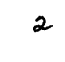

In [21]:
# At program start, load the model.
classify_digit = cntk.Function.load('mnist.cmf')

# To apply model, just call it.
image_input = X_test_mn[8345]        # (pick a random test digit for illustration)
scores = classify_digit(image_input) # call the model function with the input data
image_class = scores.argmax()        # find the highest-scoring class

# And that's it. Let's have a peek at the result
print('Recognized as:', image_class)
matplotlib.pyplot.axis('off')
_ = matplotlib.pyplot.imshow(image_input, cmap="gray_r")

_unchecked_

模型可以直接部署到用其他编程语言编写的程序中, 而绑定存在。
请参见下面的示例程序, 类似于上面的 Python 示例:

- c++:`Examples/Evaluation/CNTKLibraryCPPEvalCPUOnlyExamples/CNTKLibraryCPPEvalCPUOnlyExamples.cpp`

- c#:`Examples/Evaluation/CNTKLibraryCSEvalCPUOnlyExamples/CNTKLibraryCSEvalExamples.cs`

要从您自己的 web 服务部署模型, 请以相同的方式加载和调用模型。

要通过 Azure web 服务部署模型, 请按照以下教程操作:`Examples/Evaluation/CNTKAzureTutorial01`

_unchecked_

## 结论

本教程概述了创建和使用具有 CNTK 的深层神经网络的五主要任务。

我们首先研究了 CNTK 的函数规划及其基于张量/序列的数据模型。
然后, 我们考虑了通过 CNTK 的数据读取基础结构 ( `MinibatchSource` ) 和通过自定义 minibatch 循环进行的填鸭式的 CNTK, 将数据直接从 RAM 中送进的可能方法。
然后, 我们看了 CNTK 的高级培训选项, 包括分布式培训、日志记录到 TensorBoard、检查点、基于 CV 的培训控制和最终模型评估。
最后, 我们简要地研究了模型部署。

我们希望这引导您有您有一个好起点为您自己的事业与 CNTK。请尽情享受!